# Identifying pneumonia in X-ray images
Maciej Lorens

In [113]:
import os
from pathlib import Path
import glob
from tqdm import tqdm
from joblib import dump, load
import warnings
import numpy as np
import pandas as pd

# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchmetrics
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torchvision import  models, transforms
import lightning.pytorch as pl
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

# Sklearn
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    log_loss, 
    accuracy_score,
    average_precision_score,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Hyperparameter optimization
import optuna as opt
from optuna.integration import PyTorchLightningPruningCallback

# Image processing
from PIL import Image
from skimage.io import imread
import cv2

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sn
sn.set_theme(style="darkgrid")
import plotly.figure_factory as ff

# Shapley
import shap

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [120]:
# Plot the loss curve based on the provided folder or the latest folder from lightning logs
def plot_loss_curve(fpath=None):
    latest_file = os.path.join(fpath, "metrics.csv")
    loss_data = pd.read_csv(latest_file)
    loss_data['val_loss'] = loss_data.val_loss.shift(1)
    loss_data = loss_data[["epoch", "train_loss", "val_loss"]].dropna()
    loss_data['epoch'] = loss_data.epoch

    plt.figure(figsize=(10,5))
    plt.plot(loss_data['epoch'], loss_data['train_loss'], label="Training loss")
    plt.plot(loss_data['epoch'], loss_data['val_loss'], label = "Validation loss")
    plt.title("Loss curve", fontsize=18)
    plt.xlabel("Epoch", fontsize=16)
    plt.ylabel("Loss metric", fontsize=16)
    plt.xticks(loss_data['epoch'])
    plt.legend(loc="upper right", fontsize=16)
    plt.tight_layout()
    plt.show()


# Get the best threshold for classification with g-mean
def get_best_threshold(y_true, preds):
    # Get best threshold value
    fpr, tpr, thresholds = roc_curve(y_true, preds)
    # Calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    # Locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# Data exploration

In [2]:
# Path to the images of X-rays
data_dir = Path("chest_xray")

# Path to the train directory
train_dir = data_dir / "train"

# Path to test directory
test_dir = data_dir / "test"

In [3]:
# Get a dataframe of image paths and labels
def get_image_df(img_dir):
    # Paths to normal and pneumonia xrays
    normal_dir = img_dir / "NORMAL"
    pneumonia_dir = img_dir / "PNEUMONIA"

    # List of all the images
    normal_cases = normal_dir.glob("*.jpeg")
    pneumonia_cases = pneumonia_dir.glob("*.jpeg")

    data = []

    for img in normal_cases:
        data.append((img, 0))

    for img in pneumonia_cases:
        data.append((img, 1))

    data = pd.DataFrame(data, columns=["Image_dir", "Label"])

    return data

In [4]:
train_data = get_image_df(train_dir)
test_data = get_image_df(test_dir)

In [7]:
train_data.head()

,Image_dir,Label
0,chest_xray/train/NORMAL/NORMAL2-IM-0687-0001.jpeg,0
1,chest_xray/train/NORMAL/NORMAL2-IM-1067-0001-0...,0
2,chest_xray/train/NORMAL/NORMAL2-IM-1164-0001.jpeg,0
3,chest_xray/train/NORMAL/IM-0651-0001.jpeg,0
4,chest_xray/train/NORMAL/IM-0652-0001-0002.jpeg,0


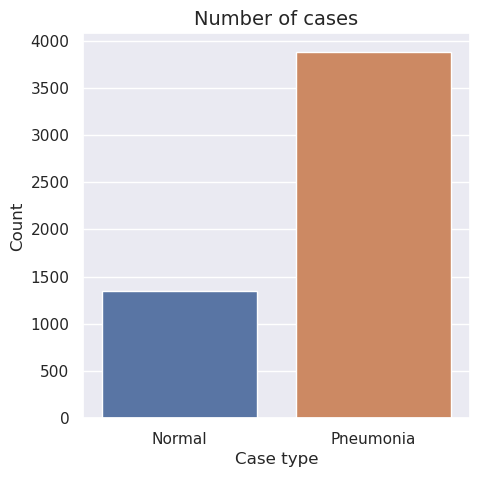

In [14]:
# Get the counts for each class
cases_count = train_data['Label'].value_counts()

# Plot the results 
plt.figure(figsize=(5, 5))
sn.barplot(x=cases_count.index, y=cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal', 'Pneumonia'])
plt.show()

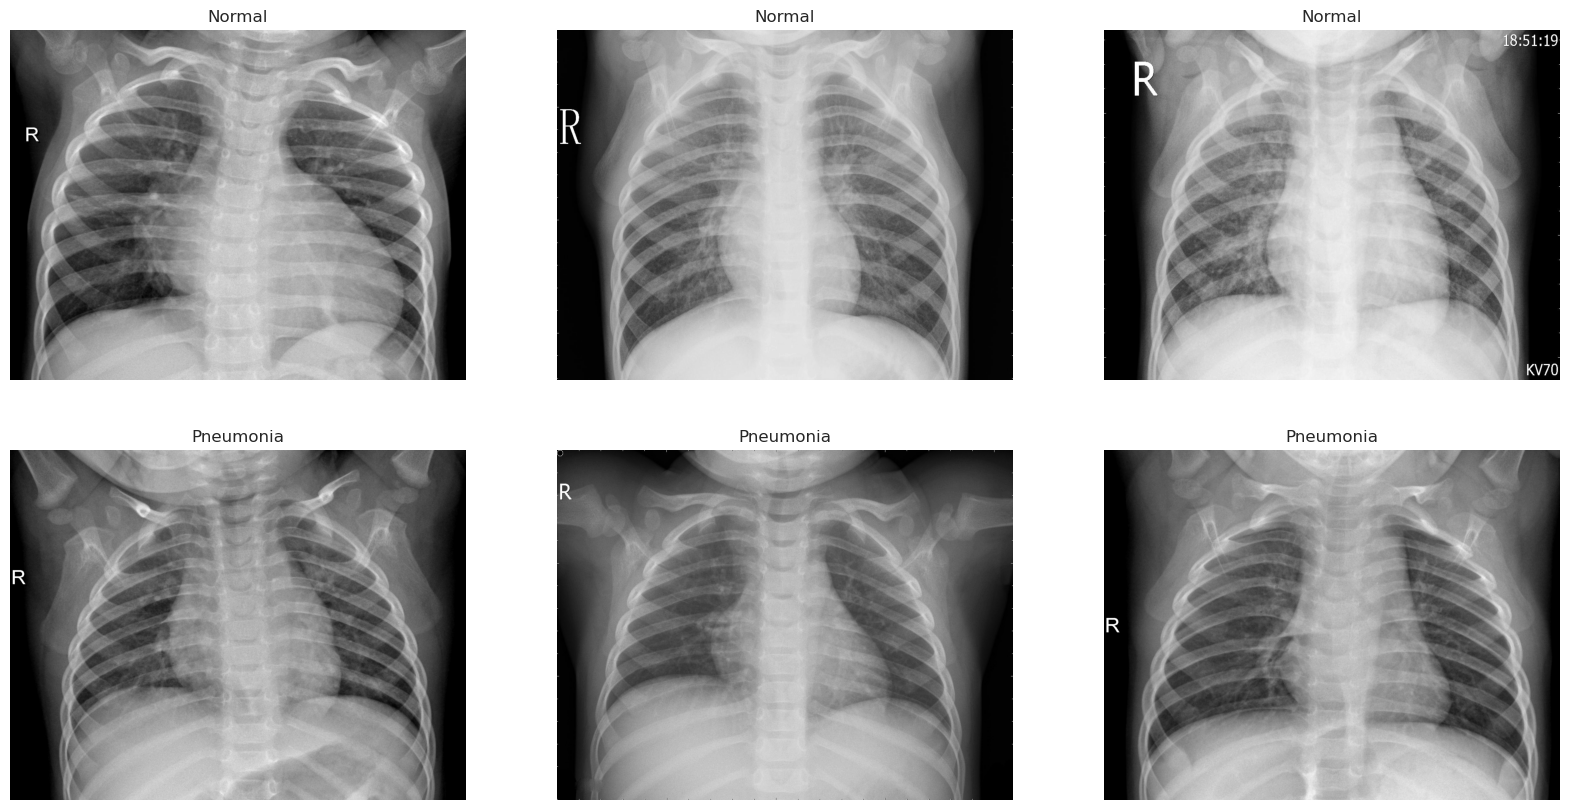

In [15]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['Label']==1]['Image_dir'].iloc[:3]).tolist()
normal_samples = (train_data[train_data['Label']==0]['Image_dir'].iloc[:3]).tolist()

# Concat the data in a single list
samples = pneumonia_samples + normal_samples

# Plot the data 
f, ax = plt.subplots(2, 3, figsize=(20, 10))
for i in range(6):
    img = imread(samples[i])
    ax[i//3, i%3].imshow(img, cmap='gray')
    if i<3:
        ax[i//3, i%3].set_title("Normal")
    else:
        ax[i//3, i%3].set_title("Pneumonia")
    ax[i//3, i%3].axis('off')
    ax[i//3, i%3].set_aspect('auto')
plt.show()

In [5]:
# Splitting train data into train and validation set
train_data, val_data = train_test_split(train_data, test_size=0.3, shuffle=True, stratify=train_data["Label"], random_state=42)
train_data, val_data = train_data.reset_index(drop=True), val_data.reset_index(drop=True)

In [6]:
print(f"Pneumonia cases in the trainining set: {train_data['Label'].value_counts()[1]}, Normal cases in the trainining set: {train_data['Label'].value_counts()[0]}")
print(f"Pneumonia cases in the validation set: {val_data['Label'].value_counts()[1]}, Normal cases in the validation set: {val_data['Label'].value_counts()[0]}")

Pneumonia cases in the trainining set: 2718, Normal cases in the trainining set: 944
Pneumonia cases in the validation set: 1165, Normal cases in the validation set: 405


# Modeling

## Dataset and Dataloader

In [7]:
# Custom PyTorch dataset of images
class ImageDataset(Dataset):
    def __init__(self, data, transform, device=device):
        self.data = data
        self.transform = transform
        self.device = device
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        image_dir = self.data.Image_dir[index]
        image = Image.open(image_dir)
        label = self.data.Label[index]
        image = self.transform(image)
        # If image is greyscale then dstack
        if image.shape[0] == 1:
            image = torch.cat((image, image, image), dim=0)
        
        post_transform = transforms.Compose([
            torchvision.transforms.Lambda(lambda x: x * (1 / 255))
            , torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
        
        image = post_transform(image)

        return (image, torch.tensor(label).to(torch.float32).to(self.device))

In [8]:
# PyTorch Lightning dataloader
class PneumoniaDataLoader(pl.LightningDataModule):
    def __init__(self, train_data, val_data, test_data, random_state, batch_size, num_workers, device):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.test_data = test_data
        self.random_sate = random_state
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage):
        # Data transformations for training
        train_transforms = transforms.Compose([
            transforms.Resize((150,150)),
            transforms.RandomRotation(30),
            transforms.RandomHorizontalFlip(p=0.4),
            transforms.ToTensor()
        ])

        # Data transformations for validation and testing
        test_transforms = transforms.Compose([
            transforms.Resize((150,150)),
            transforms.ToTensor()
        ])

        # Create three instances of the custom dataset class
        self.image_train = ImageDataset(self.train_data, transform=train_transforms)
        self.image_val = ImageDataset(self.val_data, transform=test_transforms)
        self.image_test = ImageDataset(self.test_data, transform=test_transforms)

    def train_dataloader(self):
        # Return the dataloader of train data
        return DataLoader(self.image_train
                          , shuffle=True
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          , persistent_workers=True
                          )

    def val_dataloader(self):
        # Return the dataloader of validation data
        return DataLoader(self.image_val
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          , persistent_workers=True
                          )

    def test_dataloader(self):
        # Return the dataloader of test data
        return DataLoader(self.image_test
                          , shuffle=False
                          , batch_size=self.batch_size
                          , drop_last=False
                          , num_workers=self.num_workers
                          , persistent_workers=True
                          )

## PyTorch Models

In [9]:
# Benchmark simple CNN model class
class BenchmarkCNNModel(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(18496, 120) # 16 * 34 * 34
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.softmax = nn.Sigmoid()
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(self.dropout(F.relu(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x
    

# Transfer learning model with VGG16 for the stacking ensemble
class VGG16Model(nn.Module):
    def __init__(self, dropout):
        super().__init__()
        self.vgg16 = models.vgg16_bn(weights=torchvision.models.VGG16_BN_Weights.DEFAULT)
        num_features = self.vgg16.classifier[-1].in_features
        features = list(self.vgg16.classifier.children())[:-1]
        self.fn = nn.Linear(num_features, 1)
        self.vgg16.classifier = nn.Sequential(*features)
        self.dropout = nn.Dropout(p=dropout)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.vgg16(x)
        x = self.fn(self.dropout(x))

        return self.sigmoid(x)


# Transfer learning model with DenseNet169 for the stacking ensemble
class DenseNetModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.densenet = models.densenet169(weights=torchvision.models.DenseNet169_Weights.DEFAULT)
        self.densenet.classifier = nn.Sequential(nn.Identity()) # or nn.Dropout(p=0.2), nn.Linear(num_features, 1)
    
    def forward(self, x):
        x = self.densenet(x)

        return x
    

# Meta Model for combining outputs of two other models
class MetaModel(nn.Module):
    def __init__(self, dropout, n_neurons, activ):
        super().__init__()
        self.fn1 = nn.Linear(2, n_neurons)
        self.fn2 = nn.Linear(n_neurons, 1)
        self.activ = activ()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.activ(self.fn1(x))
        x = self.activ(self.fn2(x))


        return self.sigmoid(x)

In [10]:
# Pneumonia classification model created with lightning
class PneumoniaModel(pl.LightningModule):
    def __init__(self, model, lr=0.001):
        super().__init__()
        # Model of choice
        self.model = model
        # Learning rate
        self.lr = lr
        # Metrics
        self.bce = nn.BCELoss()

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        train_loss = self.bce(y_pred.squeeze(), y)
        self.log("train_loss", train_loss, logger=True, prog_bar=True, on_step=False, on_epoch=True)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        val_loss = self.bce(y_pred.squeeze(), y)
        self.log("val_loss", val_loss, logger=True, prog_bar=True, on_step=False, on_epoch=True)

    def test_step(self, batch, batch_idx):
        X, y = batch
        y_pred = self.model(X)
        test_loss = self.bce(y_pred.squeeze(), y)
        self.log("test_loss", test_loss, prog_bar=True, on_step=False, on_epoch=True, sync_dist=True)
    
    def predict_step(self, batch, batch_id):
        X, _ = batch
        y_pred = self.model(X)

        return y_pred

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

## Model training and validation

In [11]:
# Initialize dataloader
pneumonia_loader = PneumoniaDataLoader(train_data=train_data
                                       , val_data=val_data
                                       , test_data=test_data
                                       , random_state=42
                                       , batch_size=128
                                       , num_workers=8
                                       , device=device
                                       )

### Benchmark model

#### Hyperparameter optimization

In [ ]:
pl.seed_everything(42, workers=True)
warnings.filterwarnings("ignore", category=UserWarning, module="optuna")

def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    dropout = trial.suggest_categorical("dropout", [0.2, 0.4])
    lr = trial.suggest_categorical("lr", [1e-3, 1e-2])

    benchmark_model = BenchmarkCNNModel(dropout=dropout).to(device)
    model = PneumoniaModel(benchmark_model, lr=lr)

    optuna_loader = PneumoniaDataLoader(train_data=train_data
                                        , val_data=val_data
                                        , test_data=test_data
                                        , random_state=42
                                        , batch_size=batch_size
                                        , num_workers=0
                                        , device=device
                                        )
    
    optuna_trainer = pl.Trainer(max_epochs=10
                                , enable_checkpointing=False
                                , logger=True
                                , log_every_n_steps=1
                                , check_val_every_n_epoch=1
                                # , limit_train_batches=0.2
                                # , limit_val_batches=0.2
                                , deterministic=True
                                , default_root_dir="benchmark_optuna_logs/"
                                , callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_loss"),
                                             EarlyStopping(monitor="val_loss", mode="min")])
    
    hyperparameters = dict(batch_size=batch_size, dropout=dropout, lr=lr)
    optuna_trainer.logger.log_hyperparams(hyperparameters)
    optuna_trainer.fit(model, datamodule=optuna_loader)

    return optuna_trainer.callback_metrics["val_loss"].item()

study = opt.create_study(direction="minimize", study_name="benchmark_model", pruner=opt.pruners.MedianPruner(n_warmup_steps=5), load_if_exists=True)

study.optimize(objective, n_trials=12, n_jobs=1)

print("Best hyperparameters: ", study.best_params)
print("Score on validation: ", study.best_value)

#### Training best model

In [ ]:
pl.seed_everything(42, workers=True)
benchmark_model = PneumoniaModel(BenchmarkCNNModel(dropout=0.2).to(device), lr=0.01)
benchmark_trainer = pl.Trainer(max_epochs=20
                               , check_val_every_n_epoch=1
                               , log_every_n_steps=1
                               , deterministic=True
                               , default_root_dir="benchmark_logs/"
                               , callbacks=[EarlyStopping(monitor="val_loss", mode="min")])

In [ ]:
benchmark_trainer.fit(benchmark_model, datamodule=pneumonia_loader)

In [ ]:
benchmark_trainer.test(benchmark_model, dataloaders=pneumonia_loader.test_dataloader())

### VGG16 Model

#### Hyperparameter tuning

In [24]:
pl.seed_everything(42, workers=True)
warnings.filterwarnings("ignore", category=UserWarning, module="optuna")

def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    dropout = trial.suggest_categorical("dropout", [0.2, 0.4])
    lr = trial.suggest_categorical("lr", [1e-3, 1e-2])

    vgg16_model = VGG16Model(dropout=dropout).to(device)
    vgg16_model.vgg16.requires_grad_(False)
    model = PneumoniaModel(vgg16_model, lr=lr)

    optuna_loader = PneumoniaDataLoader(train_data=train_data
                                        , val_data=val_data
                                        , test_data=test_data
                                        , random_state=42
                                        , batch_size=batch_size
                                        , num_workers=8
                                        , device=device
                                        )
    
    optuna_trainer = pl.Trainer(max_epochs=10
                                , enable_checkpointing=False
                                , logger=True
                                , log_every_n_steps=1
                                , check_val_every_n_epoch=1
                                # , limit_train_batches=0.2
                                # , limit_val_batches=0.2
                                , deterministic=True
                                , default_root_dir="vgg16_optuna_logs/"
                                , callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_loss"),
                                             EarlyStopping(monitor="val_loss", mode="min")])
    
    hyperparameters = dict(batch_size=batch_size, dropout=dropout, lr=lr)
    optuna_trainer.logger.log_hyperparams(hyperparameters)
    optuna_trainer.fit(model, datamodule=optuna_loader)

    return optuna_trainer.callback_metrics["val_loss"].item()

study = opt.create_study(direction="minimize", study_name="vgg16_model", pruner=opt.pruners.MedianPruner(n_warmup_steps=5))

study.optimize(objective, n_trials=12, n_jobs=1)

print("Best hyperparameters: ", study.best_params)
print("Score on validation: ", study.best_value)

Seed set to 42
[I 2024-01-17 00:51:57,289] A new study created in memory with name: vgg16_model
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type       | Params
-------------------------------------
0 | model | VGG16Model | 134 M 
1 | bce   | BCELoss    | 0     
-------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 02:10:06,650] Trial 0 finished with value: 0.151974156498909 and parameters: {'batch_size': 128, 'dropout': 0.4, 'lr': 0.001}. Best is trial 0 with value: 0.151974156498909.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | VGG16Model | 134 M 
1 | bce   | BCELoss    | 0     
-------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 03:27:01,803] Trial 1 finished with value: 0.1740303784608841 and parameters: {'batch_size': 256, 'dropout': 0.2, 'lr': 0.001}. Best is trial 0 with value: 0.151974156498909.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | VGG16Model | 134 M 
1 | bce   | BCELoss    | 0     
-------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 04:21:17,391] Trial 2 finished with value: 0.20916269719600677 and parameters: {'batch_size': 128, 'dropout': 0.2, 'lr': 0.01}. Best is trial 0 with value: 0.151974156498909.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | VGG16Model | 134 M 
1 | bce   | BCELoss    | 0     
-------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 05:38:25,104] Trial 3 finished with value: 0.16845107078552246 and parameters: {'batch_size': 256, 'dropout': 0.4, 'lr': 0.001}. Best is trial 0 with value: 0.151974156498909.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | VGG16Model | 134 M 
1 | bce   | BCELoss    | 0     
-------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 06:55:57,752] Trial 4 finished with value: 0.15291762351989746 and parameters: {'batch_size': 256, 'dropout': 0.2, 'lr': 0.01}. Best is trial 0 with value: 0.151974156498909.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | VGG16Model | 134 M 
1 | bce   | BCELoss    | 0     
-------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 07:42:43,583] Trial 5 pruned. Trial was pruned at epoch 5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | VGG16Model | 134 M 
1 | bce   | BCELoss    | 0     
-------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 09:00:12,400] Trial 6 finished with value: 0.16076110303401947 and parameters: {'batch_size': 128, 'dropout': 0.4, 'lr': 0.001}. Best is trial 0 with value: 0.151974156498909.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | VGG16Model | 134 M 
1 | bce   | BCELoss    | 0     
-------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 10:15:55,872] Trial 7 finished with value: 0.2042691558599472 and parameters: {'batch_size': 256, 'dropout': 0.4, 'lr': 0.01}. Best is trial 0 with value: 0.151974156498909.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | VGG16Model | 134 M 
1 | bce   | BCELoss    | 0     
-------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 11:32:39,108] Trial 8 finished with value: 0.16582447290420532 and parameters: {'batch_size': 128, 'dropout': 0.4, 'lr': 0.001}. Best is trial 0 with value: 0.151974156498909.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | VGG16Model | 134 M 
1 | bce   | BCELoss    | 0     
-------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 12:40:59,870] Trial 9 pruned. Trial was pruned at epoch 8.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | VGG16Model | 134 M 
1 | bce   | BCELoss    | 0     
-------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 13:28:07,350] Trial 10 finished with value: 0.27675652503967285 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01}. Best is trial 0 with value: 0.151974156498909.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type       | Params
-------------------------------------
0 | model | VGG16Model | 134 M 
1 | bce   | BCELoss    | 0     
-------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 14:07:02,154] Trial 11 finished with value: 0.20978793501853943 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01}. Best is trial 0 with value: 0.151974156498909.


Best hyperparameters:  {'batch_size': 128, 'dropout': 0.4, 'lr': 0.001}
Score on validation:  0.151974156498909


#### Training the best model

In [12]:
pl.seed_everything(42, workers=True)
vgg16_model = VGG16Model(dropout=0.4).to(device)
vgg16_model.vgg16.requires_grad_(False)

vgg16_model_lightning = PneumoniaModel(vgg16_model, lr=0.001)
vgg16_trainer = pl.Trainer(max_epochs=20
                           , check_val_every_n_epoch=1
                           , log_every_n_steps=1
                           , deterministic=True
                           , default_root_dir="vgg16_logs/"
                           , callbacks=[EarlyStopping(monitor="val_loss", mode="min")])

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [26]:
vgg16_trainer.fit(vgg16_model_lightning, datamodule=pneumonia_loader)

Missing logger folder: vgg16_logs/lightning_logs

  | Name  | Type       | Params
-------------------------------------
0 | model | VGG16Model | 134 M 
1 | bce   | BCELoss    | 0     
-------------------------------------
4.1 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.092   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [106]:
vgg16_preds = vgg16_trainer.predict(vgg16_model_lightning, dataloaders=pneumonia_loader.val_dataloader())
vgg16_preds = np.hstack([pred.squeeze(1).detach().cpu().numpy() for pred in vgg16_preds])

Predicting: |          | 0/? [00:00<?, ?it/s]

In [110]:
get_best_threshold(np.array(val_data['Label']), vgg16_preds)

Best Threshold=0.481709, G-Mean=0.463


### Densenet169 and SVM Classifier

#### Special dataloaders for Densenet169 with SVM Classifier

In [29]:
svc_train_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.RandomRotation(30),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.ToTensor()
])

svc_test_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor()
])

# Create three instances of the custom dataset class
svc_image_train = ImageDataset(train_data, transform=svc_train_transforms)
svc_image_val = ImageDataset(val_data, transform=svc_test_transforms)
svc_image_test = ImageDataset(test_data, transform=svc_test_transforms)

svc_train_loader = DataLoader(svc_image_train
                              , shuffle=False 
                              # Batch size doesn't matter here, since we're not training the CNN
                              , drop_last=False
                              , num_workers=8
                              )

svc_val_loader = DataLoader(svc_image_val
                            , shuffle=False
                            # Batch size doesn't matter here, since we're not training the CNN
                            , batch_size=128
                            , drop_last=False
                            , num_workers=8
                            )

svc_test_loader = DataLoader(svc_image_test
                             , shuffle=False
                             # Batch size doesn't matter here, since we're not training the CNN
                             , batch_size=128
                             , drop_last=False
                             , num_workers=8
                             )

#### Initialize DenseNet169 with pretrained weights

In [13]:
pl.seed_everything(42, workers=True)
densenet_model = DenseNetModel().to(device)
densenet_model.densenet.requires_grad_(False)

Seed set to 42


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [14]:
def get_densenet_predictions(dataloader, model, device):
    model.eval()
    cnn_preds_all = []

    for X, _ in tqdm(dataloader, total=len(dataloader)):
        cnn_preds = model(X)
        cnn_preds_all += [cnn_preds.detach().cpu().numpy()]
    
    cnn_preds_all = np.concatenate(cnn_preds_all, axis=0)
    
    return cnn_preds_all

In [78]:
svc_train_features = get_densenet_predictions(svc_train_loader, densenet_model, device)
svc_val_features = get_densenet_predictions(svc_val_loader, densenet_model, device)

100%|██████████| 13/13 [02:44<00:00, 12.63s/it]


#### SVM Classifier

##### Hyperparameter tuning

In [28]:
# Tuning SVC hyperparameters with Optuna
def objective(trial):
    
    params = dict(
        C = trial.suggest_float("C", 1e-2, 1e-1),
        kernel = trial.suggest_categorical("kernel", ["linear", "rbf"]),
        class_weight = trial.suggest_categorical("class_weight", ["balanced", None])
    )

    svc_model = SVC(**params, probability=True, random_state=42)

    svc_pipe = Pipeline([("scaler", StandardScaler())
                     , ("model", svc_model)])

    svc_pipe.fit(svc_train_features, np.array(train_data["Label"]))

    score = log_loss(np.array(val_data["Label"]), svc_pipe.predict(svc_val_features))

    return score

study = opt.create_study(direction="minimize", study_name="svc", pruner=opt.pruners.HyperbandPruner())

study.optimize(objective, n_trials=100, n_jobs=-1)

print("Best hyperparameters: ", study.best_params)
print("Score on validation: ", study.best_value)

[I 2024-01-17 20:29:34,877] A new study created in memory with name: svc
[I 2024-01-17 20:31:29,957] Trial 6 finished with value: 2.158027655144594 and parameters: {'C': 0.09820392758269227, 'kernel': 'linear', 'class_weight': 'balanced'}. Best is trial 6 with value: 2.158027655144594.
[I 2024-01-17 20:31:33,487] Trial 7 finished with value: 2.158027655144594 and parameters: {'C': 0.09726796430404021, 'kernel': 'linear', 'class_weight': 'balanced'}. Best is trial 6 with value: 2.158027655144594.
[I 2024-01-17 20:31:34,910] Trial 5 finished with value: 2.295774101217653 and parameters: {'C': 0.07745441721534614, 'kernel': 'linear', 'class_weight': 'balanced'}. Best is trial 6 with value: 2.158027655144594.
[I 2024-01-17 20:31:35,556] Trial 2 finished with value: 2.1350699141324174 and parameters: {'C': 0.06490778622457671, 'kernel': 'linear', 'class_weight': None}. Best is trial 2 with value: 2.1350699141324174.
[I 2024-01-17 20:31:36,411] Trial 0 finished with value: 2.158027655144594 

Best hyperparameters:  {'C': 0.010159616978396761, 'kernel': 'linear', 'class_weight': 'balanced'}
Score on validation:  1.7907037989497694


##### Training SVM

In [29]:
svc_model = SVC(**study.best_params, probability=True, random_state=42)

svc_pipe = Pipeline([("scaler", StandardScaler())
                    , ("model", svc_model)])

In [30]:
svc_pipe.fit(svc_train_features, np.array(train_data["Label"]))

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 SVC(C=0.010159616978396761, class_weight='balanced',
                     kernel='linear', probability=True, random_state=42))])

In [93]:
svc_train_preds = svc_pipe.predict_proba(svc_train_features)
svc_val_preds = svc_pipe.predict_proba(svc_val_features)

In [94]:
get_best_threshold(np.array(val_data['Label']), svc_val_preds[:, 1])

Best Threshold=0.805823, G-Mean=0.942


In [98]:
print(f"Training set ROC-AUC score: {roc_auc_score(np.array(train_data['Label']), svc_train_preds[:, 1])}")
print(f"Training set balanced accuracy: {balanced_accuracy_score(np.array(train_data['Label']), svc_train_preds[:, 1] > 0.8)}")
print(f"Training set f1-score: {f1_score(np.array(train_data['Label']), svc_train_preds[:, 1] > 0.8)}")
print("-" * 50)
print(f"Validation set ROC-AUC score: {roc_auc_score(np.array(val_data['Label']), svc_val_preds[:, 1])}")
print(f"Validation set balanced accuracy: {balanced_accuracy_score(np.array(val_data['Label']), svc_val_preds[:, 1] > 0.8)}")
print(f"Validation set f1-score: {f1_score(np.array(val_data['Label']), svc_val_preds[:, 1] > 0.8)}")

Training set ROC-AUC score: 0.9837853185293275
Training set balanced accuracy: 0.943293532757137
Training set f1-score: 0.9523628048780488
--------------------------------------------------
Validation set ROC-AUC score: 0.9810925660997192
Validation set balanced accuracy: 0.940433423409103
Validation set f1-score: 0.9607329842931938


In [34]:
# Save the best model pipeline
dump(svc_pipe, 'svc_pipeline.joblib') 

['svc_pipeline.joblib']

### Stacking of the two models

In [15]:
# Load best benchmark CNN model
# best_benchmark = PneumoniaModel.load_from_checkpoint(checkpoint_path="lightning_logs/version_10/checkpoints/epoch=1-step=58.ckpt", model=BenchmarkCNNModel(dropout=0.2), lr=0.02)

# Load best vgg16 model
best_vgg16 = PneumoniaModel.load_from_checkpoint(checkpoint_path="vgg16_logs/lightning_logs/version_0/checkpoints/epoch=12-step=377.ckpt", model=VGG16Model(dropout=0.4), lr=0.001)

# Load SVM pipeline
svc_pipe = load("svc_pipeline.joblib")

#### Preparing the input data for the meta-learner

In [16]:
# Get predictions of Densenet+SVM and VGG16 as input for the meta-learner
def get_meta_data(image_df, shuffle=False):
    image_transforms = transforms.Compose([
        transforms.Resize((150,150)),
        transforms.ToTensor()
    ])
    meta_loader = DataLoader(ImageDataset(image_df, transform=image_transforms)
                             , shuffle=shuffle
                             # Batch size doesn't matter here, since we're not training the CNN
                             , batch_size=128
                             , drop_last=False
                             , num_workers=8
                             )
    
    vgg16_preds = vgg16_trainer.predict(best_vgg16, dataloaders=meta_loader)
    vgg16_preds = np.hstack([pred.squeeze(1).detach().cpu().numpy() for pred in vgg16_preds])
    
    svm_features = get_densenet_predictions(meta_loader, densenet_model, device)

    svm_preds = svc_pipe.predict_proba(svm_features)[:, 1]

    return np.concatenate((vgg16_preds.reshape(-1, 1), svm_preds.reshape(-1, 1)), axis=1), np.array(image_df["Label"])

In [17]:
# Create new dataloaders with the meta-learner input data
X_train, y_train = get_meta_data(train_data)
X_val, y_val = get_meta_data(val_data)
X_test, y_test = get_meta_data(test_data)

meta_train_dataset = TensorDataset(torch.from_numpy(X_train).unsqueeze(1).to(torch.float32).to(device), torch.from_numpy(y_train).to(torch.float32).to(device))
meta_val_dataset = TensorDataset(torch.from_numpy(X_val).unsqueeze(1).to(torch.float32).to(device), torch.from_numpy(y_val).to(torch.float32).to(device))
meta_test_dataset = TensorDataset(torch.from_numpy(X_test).unsqueeze(1).to(torch.float32).to(device), torch.from_numpy(y_test).to(torch.float32).to(device))

Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 29/29 [03:11<00:00,  6.59s/it]


Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 13/13 [01:24<00:00,  6.48s/it]


Predicting: |          | 0/? [00:00<?, ?it/s]

100%|██████████| 5/5 [00:35<00:00,  7.10s/it]


#### Hyperparameter optimization

In [18]:
pl.seed_everything(42, workers=True)
warnings.filterwarnings("ignore", category=UserWarning, module="optuna")

def objective(trial):
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    dropout = trial.suggest_categorical("dropout", [0.2, 0.4])
    lr = trial.suggest_categorical("lr", [1e-3, 1e-2])
    n_neurons = trial.suggest_categorical("n_neurons", [2, 4, 6, 8])
    activ = trial.suggest_categorical("activ", [nn.Identity, nn.Sigmoid, nn.ReLU])

    meta_model = MetaModel(dropout=dropout, n_neurons=n_neurons, activ=activ).to(device)
    model = PneumoniaModel(meta_model, lr=lr)
    
    optuna_train_loader = DataLoader(meta_train_dataset, shuffle=True, batch_size=batch_size, num_workers=8)
    optuna_val_loader = DataLoader(meta_val_dataset, shuffle=False, batch_size=batch_size, num_workers=8)
    
    optuna_trainer = pl.Trainer(max_epochs=10
                                , enable_checkpointing=False
                                , logger=True
                                , log_every_n_steps=1
                                , check_val_every_n_epoch=1
                                # , limit_train_batches=0.2
                                # , limit_val_batches=0.2
                                , deterministic=True
                                , default_root_dir="meta_optuna_logs/"
                                , callbacks=[PyTorchLightningPruningCallback(trial, monitor="val_loss"),
                                             EarlyStopping(monitor="val_loss", mode="min")])
    
    hyperparameters = dict(batch_size=batch_size, dropout=dropout, lr=lr)
    optuna_trainer.logger.log_hyperparams(hyperparameters)
    optuna_trainer.fit(model, train_dataloaders=optuna_train_loader, val_dataloaders=optuna_val_loader)

    return optuna_trainer.callback_metrics["val_loss"].item()

study = opt.create_study(direction="minimize", study_name="meta_model", pruner=opt.pruners.MedianPruner(n_warmup_steps=5))

study.optimize(objective, n_trials=48, n_jobs=1)

print("Best hyperparameters: ", study.best_params)
print("Score on validation: ", study.best_value)

Seed set to 42
[I 2024-01-17 21:56:39,618] A new study created in memory with name: meta_model
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 21:56:57,253] Trial 0 finished with value: 0.12222685664892197 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 0 with value: 0.12222685664892197.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 21:57:04,204] Trial 1 finished with value: 0.6931471824645996 and parameters: {'batch_size': 256, 'dropout': 0.4, 'lr': 0.001, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 0 with value: 0.12222685664892197.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 17    
1 | bce   | BCELoss   | 0     
------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 21:57:22,493] Trial 2 finished with value: 0.2548336088657379 and parameters: {'batch_size': 128, 'dropout': 0.4, 'lr': 0.01, 'n_neurons': 4, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 0 with value: 0.12222685664892197.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 21:57:43,465] Trial 3 finished with value: 0.5456343293190002 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.001, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.activation.Sigmoid'>}. Best is trial 0 with value: 0.12222685664892197.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 9     
1 | bce   | BCELoss   | 0     
------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 21:58:01,440] Trial 4 finished with value: 0.45709824562072754 and parameters: {'batch_size': 128, 'dropout': 0.2, 'lr': 0.001, 'n_neurons': 2, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 0 with value: 0.12222685664892197.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 17    
1 | bce   | BCELoss   | 0     
------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 21:58:14,144] Trial 5 pruned. Trial was pruned at epoch 5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 9     
1 | bce   | BCELoss   | 0     
------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 21:58:21,938] Trial 6 finished with value: 0.6931471824645996 and parameters: {'batch_size': 128, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 2, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 0 with value: 0.12222685664892197.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 9     
1 | bce   | BCELoss   | 0     
------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 21:58:32,483] Trial 7 pruned. Trial was pruned at epoch 5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 25    
1 | bce   | BCELoss   | 0     
------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 21:58:39,715] Trial 8 finished with value: 0.6931471824645996 and parameters: {'batch_size': 256, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 6, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 0 with value: 0.12222685664892197.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 9     
1 | bce   | BCELoss   | 0     
------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 21:58:51,116] Trial 9 pruned. Trial was pruned at epoch 5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 21:59:06,611] Trial 10 finished with value: 0.12055395543575287 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 21:59:28,424] Trial 11 finished with value: 0.12151103466749191 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48d6b9b0a0>
Traceback (most recent call last):
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f48d6b9b0a0>  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

Traceback (most recent call last):
      File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
if w.is_alive():    
self._shutdown_workers()  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 21:59:45,474] Trial 12 finished with value: 0.12404641509056091 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 21:59:58,339] Trial 13 finished with value: 0.12436296045780182 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 25    
1 | bce   | BCELoss   | 0     
------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 22:00:19,291] Trial 14 finished with value: 0.122763991355896 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 6, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:00:32,254] Trial 15 finished with value: 0.121803879737854 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:00:46,968] Trial 16 finished with value: 0.12256874144077301 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:00:57,850] Trial 17 finished with value: 0.1212860569357872 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 25    
1 | bce   | BCELoss   | 0     
------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:01:10,494] Trial 18 pruned. Trial was pruned at epoch 5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 17    
1 | bce   | BCELoss   | 0     
------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:01:21,888] Trial 19 pruned. Trial was pruned at epoch 5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:01:36,895] Trial 20 finished with value: 0.12192420661449432 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 22:01:58,188] Trial 21 finished with value: 0.12851445376873016 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 22:02:19,344] Trial 22 finished with value: 0.12195645272731781 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:02:32,606] Trial 23 finished with value: 0.1219121441245079 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:02:48,186] Trial 24 finished with value: 0.12197025865316391 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:03:06,710] Trial 25 finished with value: 0.12328122556209564 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:03:20,582] Trial 26 pruned. Trial was pruned at epoch 5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 17    
1 | bce   | BCELoss   | 0     
------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:03:36,130] Trial 27 pruned. Trial was pruned at epoch 6.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 25    
1 | bce   | BCELoss   | 0     
------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:03:48,263] Trial 28 pruned. Trial was pruned at epoch 5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:03:55,928] Trial 29 finished with value: 0.6931471824645996 and parameters: {'batch_size': 256, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:04:14,286] Trial 30 finished with value: 0.12466562539339066 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:04:27,608] Trial 31 finished with value: 0.1242218092083931 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:04:40,622] Trial 32 finished with value: 0.12656453251838684 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 10 with value: 0.12055395543575287.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:04:58,021] Trial 33 finished with value: 0.12039458751678467 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 33 with value: 0.12039458751678467.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:05:07,164] Trial 34 finished with value: 0.6931474208831787 and parameters: {'batch_size': 64, 'dropout': 0.4, 'lr': 0.001, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 33 with value: 0.12039458751678467.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:05:20,574] Trial 35 finished with value: 0.12169504165649414 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 33 with value: 0.12039458751678467.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 17    
1 | bce   | BCELoss   | 0     
------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:05:31,786] Trial 36 pruned. Trial was pruned at epoch 5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:05:49,448] Trial 37 finished with value: 0.12730102241039276 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 33 with value: 0.12039458751678467.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 9     
1 | bce   | BCELoss   | 0     
------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:06:00,946] Trial 38 pruned. Trial was pruned at epoch 5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:06:14,983] Trial 39 pruned. Trial was pruned at epoch 5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 9     
1 | bce   | BCELoss   | 0     
------------------------------------
9         Trainable params
0         Non-trainable params
9         Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48d6b9b0a0>
Traceback (most recent call last):
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7f48d6b9b0a0>
self._shutdown_workers()Traceback (most recent call last):

  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        self._shutdown_workers()if w.is_alive():

  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/multiprocessing/process.py", line 160, i

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:06:33,567] Trial 40 pruned. Trial was pruned at epoch 5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 22:06:55,698] Trial 41 finished with value: 0.12342014908790588 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 33 with value: 0.12039458751678467.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:07:14,509] Trial 42 finished with value: 0.12294647842645645 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 33 with value: 0.12039458751678467.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 22:07:38,601] Trial 43 finished with value: 0.12536630034446716 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 33 with value: 0.12039458751678467.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-01-17 22:08:01,806] Trial 44 finished with value: 0.12899111211299896 and parameters: {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}. Best is trial 33 with value: 0.12039458751678467.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 25    
1 | bce   | BCELoss   | 0     
------------------------------------
25        Trainable params
0         Non-trainable params
25        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:08:14,322] Trial 45 pruned. Trial was pruned at epoch 5.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:08:25,323] Trial 46 finished with value: 0.6931474208831787 and parameters: {'batch_size': 64, 'dropout': 0.4, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.activation.ReLU'>}. Best is trial 33 with value: 0.12039458751678467.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 17    
1 | bce   | BCELoss   | 0     
------------------------------------
17        Trainable params
0         Non-trainable params
17        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[I 2024-01-17 22:08:41,271] Trial 47 pruned. Trial was pruned at epoch 5.


Best hyperparameters:  {'batch_size': 64, 'dropout': 0.2, 'lr': 0.01, 'n_neurons': 8, 'activ': <class 'torch.nn.modules.linear.Identity'>}
Score on validation:  0.12039458751678467


#### Training the meta-learner

In [19]:
meta_train_loader = DataLoader(meta_train_dataset, shuffle=True, batch_size=64, num_workers=8)
meta_val_loader = DataLoader(meta_val_dataset, shuffle=False, batch_size=64, num_workers=8)
meta_test_loader = DataLoader(meta_test_dataset, shuffle=False, batch_size=64, num_workers=8)

In [24]:
pl.seed_everything(42, workers=True)
meta_model = MetaModel(dropout=0.2, n_neurons=8, activ=nn.Identity).to(device)

meta_model_lightning = PneumoniaModel(meta_model, lr=0.01)
meta_trainer = pl.Trainer(max_epochs=20
                          , check_val_every_n_epoch=1
                          , log_every_n_steps=1
                          , deterministic=True
                          , default_root_dir="meta_logs"
                          , callbacks=EarlyStopping(monitor="val_loss", mode="min", patience=3))

Seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [25]:
meta_trainer.fit(meta_model_lightning, train_dataloaders=meta_train_loader, val_dataloaders=meta_val_loader)


  | Name  | Type      | Params
------------------------------------
0 | model | MetaModel | 33    
1 | bce   | BCELoss   | 0     
------------------------------------
33        Trainable params
0         Non-trainable params
33        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [75]:
# Get predictions from the meta learner
meta_preds = meta_trainer.predict(meta_model_lightning, dataloaders=meta_val_loader)
meta_preds = np.hstack([pred.squeeze(1, 2).detach().cpu().numpy() for pred in meta_preds])

Predicting: |          | 0/? [00:00<?, ?it/s]

In [76]:
get_best_threshold(y_val, meta_preds)

Best Threshold=0.871662, G-Mean=0.957


## Results

### Loss curves

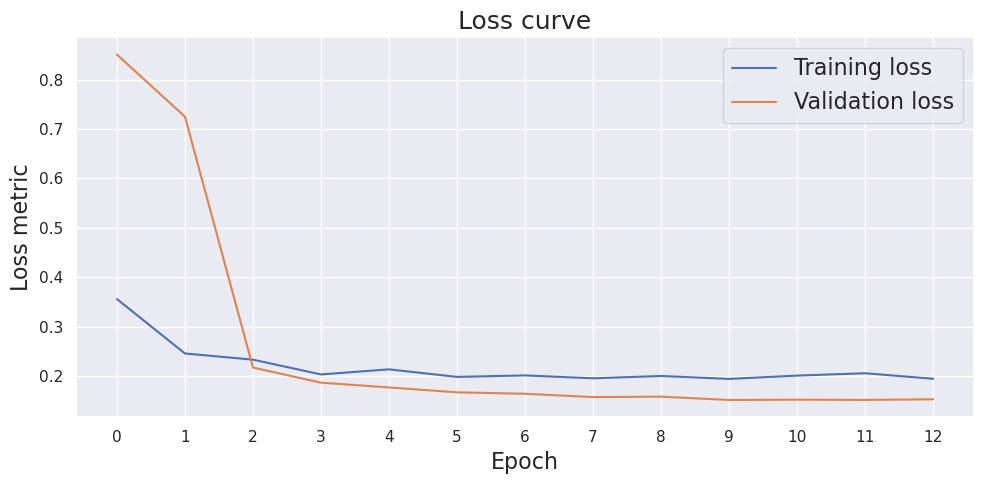

In [121]:
# Vgg-16
plot_loss_curve("vgg16_logs/lightning_logs/version_0/")

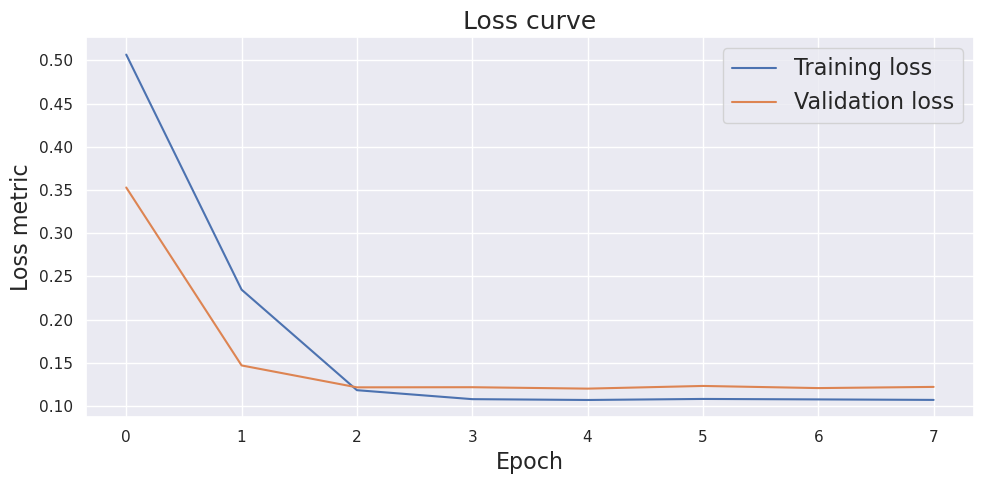

In [122]:
# Meta-learner
plot_loss_curve("meta_logs/lightning_logs/version_0/")

### Predictions

In [27]:
best_meta = PneumoniaModel.load_from_checkpoint(checkpoint_path="meta_logs/lightning_logs/version_0/checkpoints/epoch=7-step=464.ckpt", model=MetaModel(dropout=0.2, n_neurons=8, activ=nn.Identity), lr=0.01)

In [ ]:
# Get predictions from the benchmark CNN
benchmark_preds = benchmark_trainer.predict(benchmark_model, dataloaders=pneumonia_loader.test_dataloader())
benchmark_preds = np.hstack([pred.squeeze(1).detach().cpu().numpy() for pred in benchmark_preds])

In [111]:
# Get predictions from VGG16
vgg16_preds = vgg16_trainer.predict(best_vgg16, dataloaders=svc_test_loader)
vgg16_preds = np.hstack([pred.squeeze(1).detach().cpu().numpy() for pred in vgg16_preds])

Predicting: |          | 0/? [00:00<?, ?it/s]

In [99]:
# Get predictions from SVM
test_features = get_densenet_predictions(svc_test_loader, densenet_model, device)
svc_test_preds = svc_pipe.predict_proba(test_features)[:, 1]

100%|██████████| 5/5 [00:52<00:00, 10.47s/it]


In [101]:
# Get predictions from the meta learner
meta_preds = meta_trainer.predict(meta_model_lightning, dataloaders=meta_test_loader)
meta_preds = np.hstack([pred.squeeze(1, 2).detach().cpu().numpy() for pred in meta_preds])

Predicting: |          | 0/? [00:00<?, ?it/s]

### Performance metrics

In [115]:
# Calculate ROC-AUC score
roc_vgg16 = roc_auc_score(y_test, vgg16_preds)
roc_svc = roc_auc_score(y_test, svc_test_preds)
roc_meta = roc_auc_score(y_test, meta_preds)

# Calculate balanced accuracy score
bacc_vgg16 = balanced_accuracy_score(y_test, vgg16_preds > 0.48)
bacc_svc = balanced_accuracy_score(y_test, svc_test_preds > 0.8)
bacc_meta = balanced_accuracy_score(y_test, meta_preds > 0.87)

# Calculate f1-score score
f1_vgg16 = f1_score(y_test, vgg16_preds > 0.48)
f1_svc = f1_score(y_test, svc_test_preds > 0.8)
f1_meta = f1_score(y_test, meta_preds > 0.87)

results_df = pd.DataFrame(data=[[roc_vgg16, roc_svc, roc_meta], \
                                [bacc_vgg16, bacc_svc, bacc_meta], \
                                    [f1_vgg16, f1_svc, f1_meta]], \
                                        index=["AUC", "Balanced accuracy", "F1-score"], \
                                            columns=["VGG16", "Densenet+SVC", "Stacked model"])

In [116]:
# Plotting the pandas table with results
fig =  ff.create_table(results_df.applymap("{0:.4f}".format), index=True)
fig.update_layout(
    autosize=False,
    width=1000,
    height=400
)
# fig.write_image("visualizations/results.png", scale=2)
fig.show()

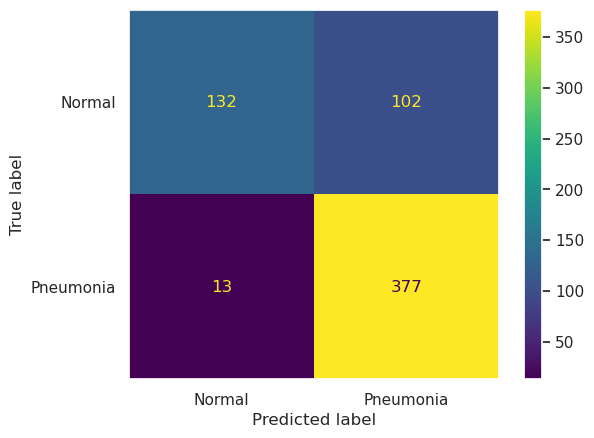

In [103]:
# Confusion matrix of stacked model predictions on the validation set
conf_matrix = confusion_matrix(np.array(test_data['Label']), meta_preds > 0.87, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["Normal", "Pneumonia"])
disp.plot()
plt.grid(False)
plt.show()

### ROC CURVE

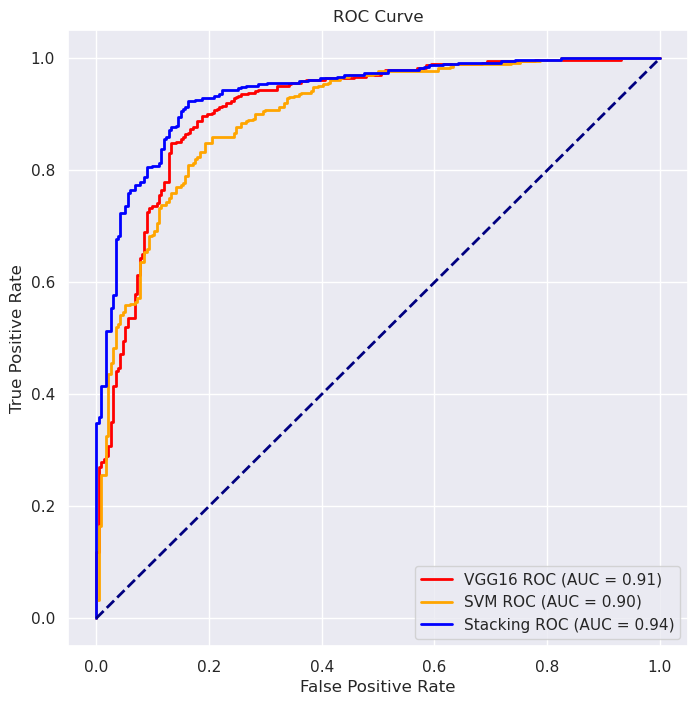

In [104]:
# Calculate ROC curve
fpr_vgg16, tpr_vgg16, _ = roc_curve(y_test, vgg16_preds)
fpr_svc, tpr_svc, _ = roc_curve(y_test, svc_test_preds)
fpr_meta, tpr_meta, thresholds = roc_curve(y_test, meta_preds)

# Visualize ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr_vgg16, tpr_vgg16, color='red', lw=2, label=f'VGG16 ROC (AUC = {roc_vgg16:.2f})')
plt.plot(fpr_svc, tpr_svc, color='orange', lw=2, label=f'SVM ROC (AUC = {roc_svc:.2f})')
plt.plot(fpr_meta, tpr_meta, color='blue', lw=2, label=f'Stacking ROC (AUC = {roc_meta:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

### SHAP values

In [ ]:
shap_sample = test_data.sample(100).reset_index(drop=True)

In [233]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

image_transforms = transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda x: x * (1 / 255)),
    torchvision.transforms.Normalize(mean=mean, std=std),
])

shap_loader = DataLoader(ImageDataset(shap_sample, transform=image_transforms)
                            , shuffle=False
                            # Batch size doesn't matter here, since we're not training the CNN
                            , batch_size=100
                            , drop_last=False
                            , num_workers=8
                            )

In [234]:
for X_batch, y_batch in shap_loader:
    X_shap = X_batch
    y_shap = y_batch

# X_shap = X_shap.detach().cpu().numpy()
# y_shap = y_shap.detach().cpu().numpy()

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_32897/1076314054.py", line 15, in __getitem__
    image = self.transform(image)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 95, in __call__
    img = t(img)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torchvision/transforms/transforms.py", line 277, in forward
    return F.normalize(tensor, self.mean, self.std, self.inplace)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torchvision/transforms/functional.py", line 363, in normalize
    return F_t.normalize(tensor, mean=mean, std=std, inplace=inplace)
  File "/home/maciej/anaconda3/envs/learn_torch/lib/python3.10/site-packages/torchvision/transforms/_functional_tensor.py", line 928, in normalize
    return tensor.sub_(mean).div_(std)
RuntimeError: output with shape [1, 150, 150] doesn't match the broadcast shape [3, 150, 150]


In [ ]:
# Meta-learner full pipeline
def meta_pipeline(X):
    # shap_dataset = TensorDataset(torch.from_numpy(X).to(torch.float32).to(device), torch.from_numpy(y_shap).to(torch.float32).to(device))
    shap_dataset = TensorDataset(torch.tensor(X), torch.ones(len(X)))
    shap_loader = DataLoader(shap_dataset, shuffle=False, batch_size=32)
    vgg16_preds = []
    for i, (X_batch, y_batch) in enumerate(shap_loader):
        vgg16_preds.append(best_vgg16.eval().predict_step((X_batch, y_batch), i))
        
    vgg16_preds = np.hstack([preds.squeeze(1).detach().cpu().numpy() for preds in vgg16_preds])
    
    svm_features = get_densenet_predictions(shap_loader, densenet_model, device)

    svm_preds = svc_pipe.predict_proba(svm_features)[:, 1]

    X_meta = np.concatenate((vgg16_preds.reshape(-1, 1), svm_preds.reshape(-1, 1)), axis=1)
    X_meta = torch.from_numpy(X_meta).unsqueeze(1).to(torch.float32).to(device)

    meta_preds = best_meta.eval().predict_step((X_meta, y_shap), 0)

    meta_preds = meta_preds.squeeze(1, 2).detach().cpu().numpy()

    return meta_preds

In [ ]:
meta_pipeline(X_shap[1:2])

In [232]:
# define a masker that is used to mask out partitions of the input image.
masker_blur = shap.maskers.Image("inpaint_telea", X_shap[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(meta_pipeline, masker_blur, output_names="Pneumonia", seed=42)

# feed only one image
# here we explain two images using 100 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(
    X_shap[1:3],
    max_evals=100,
    batch_size=32,
    outputs=shap.Explanation.argsort.flip[:1],
)

100%|██████████| 1/1 [00:00<00:00,  7.28it/s]


error: OpenCV(4.9.0) /io/opencv/modules/photo/src/inpaint.cpp:763: error: (-210:Unsupported format or combination of formats) 8-bit, 16-bit unsigned or 32-bit float 1-channel and 8-bit 3-channel input/output images are supported in function 'icvInpaint'


In [ ]:
explainer = shap.KernelExplainer(meta_pipeline, X_shap)

In [ ]:
# Calculate SHAP values for the sample data
shap_values = explainer.shap_values(X_shap[0], nsamples=1000)

In [ ]:
len(X_shap[0])